# SETUP

In [1]:
import sys
sys.path.insert(0,'..')
from spectral_cube import SpectralCube
from IPython.display import display, HTML
import seaborn as sns

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
from matplotlib.ticker import PercentFormatter
from medzoo_imports import create_model, DiceLoss, Trainer, compute_per_channel_dice
from compare_methods import Evaluator
from os import listdir
from scipy import ndimage as ndi
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from data_generators.data_loader import SegmentationDataSet
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
import torch
from datetime import datetime
from astropy.io import fits
import numpy as np
from astropy.convolution import convolve, Gaussian2DKernel
from scipy import ndimage as ndi
from skimage.util.shape import view_as_windows
import skimage.measure as skmeas
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt
import pandas as pd
import copy
import torch.backends.cudnn as cudnn
from matplotlib.cm import register_cmap
import astropy.constants as const

from numpy.lib.stride_tricks import as_strided
import pickle
from sklearn.mixture import GaussianMixture
from scipy import stats
from datetime import datetime

## Load model

Properties of pre-trained model

In [442]:
batch_size=1
dataset_name="hi_data"
root = '../'
dim=(64, 64, 64)
nEpochs=10
classes=2
inChannels=1
terminal_show_freq=50
model='VNET'
opt='adam'
log_dir='../runs/'
lr = 1e-2
dims = [128, 128, 64]
overlaps = [15, 20, 20]
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 2}
k = 0
model_name = model
date_str = ""
save = '../saved_models_12052021_183655_/fold_' + str(k) + '_checkpoints/'

Load pre-trained model

In [3]:
class argsclass:
    def __init__(self, model, opt, lr, inChannels, classes, pretrained):
        self.model = model
        self.opt=opt
        self.lr=lr
        self.inChannels=1
        self.classes=2
        self.pretrained = pretrained
model_loc = "../results/VNET__last_epoch.pth"
# args = argsclass('VNET', 'adam', 1e-2, 1, 2, model_loc)
args = argsclass('VNET', 'adam', 1e-2, 1, 2, model_loc)
model, optimizer = create_model(args)
model.restore_checkpoint(args.pretrained)
model.eval()
print("Loaded")

Building Model . . . . . . . .VNET
VNET Number of params: 45603934
Loaded


In [90]:
train_df = pd.read_csv("../saved_models_21052021_163310_loud_1/fold_%s_checkpoints/VNET_/train.csv"%k, header=None, sep=":", names=["skip", "epoch", "loss", "dsc"])
val_df = pd.read_csv("../saved_models_21052021_163310_loud_1/fold_%s_checkpoints/VNET_/val.csv"%k, header=None, sep=":", names=["skip", "epoch", "loss", "dsc"])
train_df["epoch"] = train_df["epoch"].str.split("Loss", expand=True)[0]
val_df["epoch"] = val_df["epoch"].str.split("Loss", expand=True)[0]
train_df["loss"] = train_df["loss"].str.split(" ", expand=True)[0]
val_df["loss"] = val_df["loss"].str.split(" ", expand=True)[0]

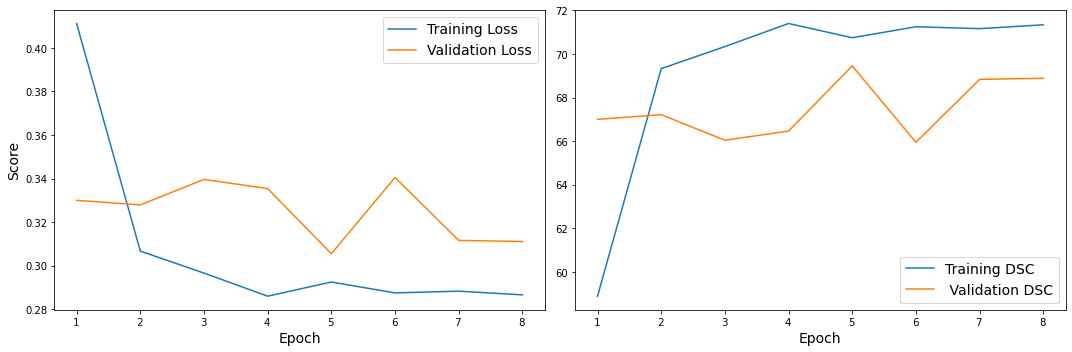

In [91]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

axes[0].plot(train_df.epoch, train_df.loss.astype(float), label="Training Loss")
axes[0].plot(val_df.epoch, val_df.loss.astype(float), label="Validation Loss")
axes[1].plot(train_df.epoch, train_df.dsc.astype(float), label="Training DSC")
axes[1].plot(val_df.epoch, val_df.dsc.astype(float), label=" Validation DSC")

axes[0].set_xlabel("Epoch", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[0].set_ylabel("Score", fontsize=14)
# axes[1].set_ylabel("Score")
axes[0].legend(fontsize=14)
axes[1].legend(fontsize=14)
fig.tight_layout()

# Evaluate Model

Load the test subcubes

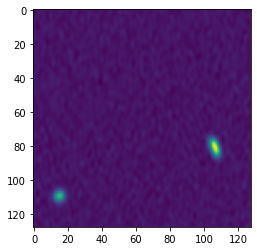

In [369]:
orig_data = fits.getdata("../data/training/loudInput/loud_1245mosC.fits")
realseg_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")
orig_subcube = orig_data[133:197, 800:800+128, 1500:1500+128]
real_subcube = realseg_data[133:197, 800:800+128, 1500:1500+128]
data_loader_tensor = torch.FloatTensor(np.moveaxis(orig_subcube, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...]
plt.imshow(orig_subcube[32])

Infer

In [380]:
model.eval()
with torch.no_grad():
    out_cube = model.inference(data_loader_tensor)
out_np = np.moveaxis(out_cube.squeeze()[1].numpy(), 2, 0)
clipped = (out_np > 0).astype(int)

Evaluate

In [383]:
mask_labels = skmeas.label(real_subcube)
mos_name = '1245mosC'
eve = Evaluator(orig_subcube, mask_labels, mos_name)
vnet_labels = skmeas.label(clipped)
evaluated = eve.get_p_score(vnet_labels)

OUTSTAT True positive: 3
OUTSTAT False negative: 0
OUTSTAT False positive: 0
OUTSTAT Recall: 1.0
OUTSTAT Precision: 1.0
OUTSTAT F score: 1.0
OUTSTAT Undermerging score: 0.003350348629474541
OUTSTAT Overmerging score: 0.0020294964993607034
OUTSTAT Total area score: 0.003917102498012949
OUTSTAT Background skew score: 181.37961810036407
OUTSTAT Background kurtosis score: 485.2702938762278
OUTSTAT Background mean score: -1.8978089e-06
OUTSTAT Combined A: 1.0000076718165616
OUTSTAT Combined B: 0.9982057674522645


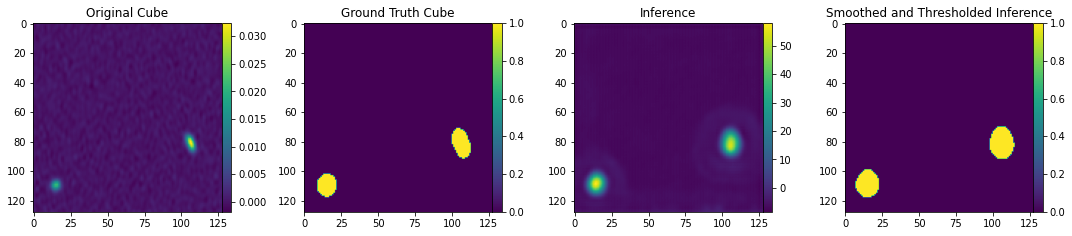

In [381]:
fig, axes = plt.subplots(1, 4, figsize = (15, 5))
im0 = axes[0].imshow(orig_subcube[32])
cax0 = make_axes_locatable(axes[0]).append_axes("right", size="5%",pad=0)
fig.colorbar(im0, cax=cax0)
axes[0].set_title("Original Cube")


im3 = axes[1].imshow(real_subcube[32])
cax3 = make_axes_locatable(axes[1]).append_axes("right", size="5%",pad=0)
fig.colorbar(im3, cax=cax3)
axes[1].set_title("Ground Truth Cube")

im1 = axes[2].imshow(out_np[32])
cax1 = make_axes_locatable(axes[2]).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)
axes[2].set_title("Inference")

im2 = axes[3].imshow(clipped[32])
cax2 = make_axes_locatable(axes[3]).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
axes[3].set_title("Smoothed and Thresholded Inference")


fig.tight_layout()

## Plot Combined Scores

In [856]:
freq_dict = {"mask_1245mosB.fits": [1401252439.970,1425092772.001],
"mask_1245mosC.fits": [1381037599.970,1404877932.001],
"mask_1245mosD.fits": [1360822751.970,1384663084.001],
"mask_1245mosE.fits": [1340607911.970,1364448244.001],
"mask_1245mosF.fits": [1320393067.970,1344233400.001],
"mask_1245mosG.fits": [1300178221.970,1324018554.001],
"mask_1245mosH.fits": [1279963378.910,1303803710.941],
"mask_1353mosB.fits": [1401179199.970,1425019532.001],
"mask_1353mosC.fits": [1380964351.970,1404804684.001],
"mask_1353mosD.fits": [1360749511.970,1384589844.001],
"mask_1353mosE.fits": [1340534667.970,1364375000.001],
"mask_1353mosF.fits": [1320319823.970,1344160156.001],
"mask_1353mosG.fits": [1300104979.970,1323945312.001],
"mask_1353mosH.fits": [1279890136.720,1303730468.751]}
df = pd.DataFrame(freq_dict.values(), columns=[["freq_1", "freq_2"]])
df["file_names"] = freq_dict.keys()
df["freq_1_round"] = np.round(df['freq_1']*1e-6).astype(int).astype(str)
df["freq_2_round"] = np.round(df['freq_2']*1e-6).astype(int).astype(str)
df['freq_labels'] = df[['freq_1_round', 'freq_2_round']].agg('-'.join, axis=1)
df.columns = df.columns.map(''.join)
df['mos_name'] = df.file_names.str.replace("mask_", "").str.replace(".fits", "")

In [863]:
df[df.mos_name.str.contains("1245")].freq_labels

0    1401-1425
1    1381-1405
2    1361-1385
3    1341-1364
4    1320-1344
5    1300-1324
6    1280-1304
Name: freq_labels, dtype: object

In [854]:
with open("../results/mto_performance_loudInput.txt", "rb") as fp:
    mto_time = pickle.load(fp)
mto_time_df = pd.DataFrame([(freq_dict[i.split("/")[-1].replace("loud", "mask")][0], m) for i,m in mto_time.items()], columns=['freq_1', 'time_taken'])
with open("../results/vnet_performance_saved_models_28052021_101114_loud_14.txt", "rb") as fp:
    vnet_time = pickle.load(fp)
vnet_time_df = pd.DataFrame([(freq_dict[i.split("/")[-1].replace("loud", "mask")][0], m) for i,m in vnet_time.items()], columns=['freq_1', 'time_taken'])
with open("../results/sofia_performance_loudInput.txt", "rb") as fp:
    sofia_time = pickle.load(fp)
sofia_time_df = pd.DataFrame([(freq_dict[i.split("/")[-1].replace("loud", "mask")][0], m) for i,m in sofia_time.items()], columns=['freq_1', 'time_taken'])


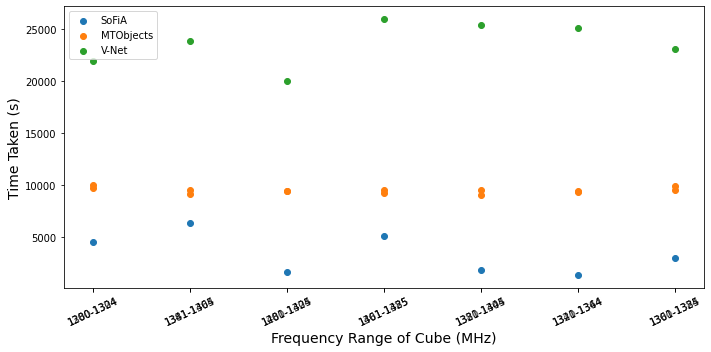

In [871]:
fig, ax = plt.subplots(figsize=(10,5), sharex=True)
ax.set_ylabel("Time Taken (s)", fontsize=14)
ax.set_xticks(ticks=mto_time_df.freq_1)
ax.set_xticklabels(df.freq_labels, rotation=25)
ax.scatter(sofia_time_df.freq_1, sofia_time_df.time_taken, label="SoFiA")
ax.scatter(mto_time_df.freq_1, mto_time_df.time_taken, label="MTObjects")
ax.scatter(vnet_time_df.freq_1, vnet_time_df.time_taken, label="V-Net")
ax.legend()
ax.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)


fig.tight_layout()

## Create catalog of sources and their attributes

In [754]:
# mto_cat_df = pd.read_csv("../results/loud_MTO_catalog.txt", index_col=0)
# vnet_cat_df = pd.read_pickle("../results/loud_VNET_catalog.txt", index_col=0)
sofia_cat_df = pd.read_csv("../results/loud_SOFIA_catalog.txt", index_col=0)
mask_cat_df = pd.read_csv("../results/loud_MASK_catalog.txt", index_col=0)

The distance $d$ in Mpc is calculated as:
\begin{align}
    d = \frac{c}{H_0}\Big{(}\frac{\nu _{rest}}{\nu} - 1\Big{)}
\end{align}
where $c$ is the speed of light and $H_0$ is the hubble constant, $\nu _{rest}$ is the rest frequency and $\nu$ is the frequency at that distance.

The physical width is the found to be $D_x$ in Mpc as follows:
\begin{align}
    D_x = d\tan(dx\Delta x )
\end{align}
where $dx$ is the pixel width in radians and $\Delta x$ is the number of pixels.

In [752]:
mto_cat_df.rename(columns={'n_freq': 'n_vel'}, inplace=True)
sofia_cat_df.rename(columns={'n_freq': 'n_vel'}, inplace=True)
# vnet_cat_df.rename(columns={'n_freq': 'n_vel'}, inplace=True)
sofia_cat_df["mos_name"] = sofia_cat_df.file.str.split("_", expand=True)[3]
mto_cat_df["mos_name"] = mto_cat_df.file.str.replace(".fits", "").str.split("_", expand=True)[3]
mask_cat_df["mos_name"] = mask_cat_df.file.str.replace(".fits", "").str.split("_", expand=True)[1]
# vnet_cat_df["mos_name"] = vnet_cat_df.file.str.replace(".fits", "").str.split("_", expand=True)[3]
d_width = 0.001666666707*u.deg
mto_cat_df["nx_kpc"] = mto_cat_df.dist*np.tan(np.deg2rad(d_width*mto_cat_df.nx))*1e3
mto_cat_df["ny_kpc"] = mto_cat_df.dist*np.tan(np.deg2rad(d_width*mto_cat_df.ny))*1e3
sofia_cat_df["nx_kpc"] = sofia_cat_df.dist*np.tan(np.deg2rad(d_width*sofia_cat_df.nx))*1e3
sofia_cat_df["ny_kpc"] = sofia_cat_df.dist*np.tan(np.deg2rad(d_width*sofia_cat_df.ny))*1e3
mask_cat_df["nx_kpc"] = mask_cat_df.dist*np.tan(np.deg2rad(d_width*mask_cat_df.nx))*1e3
mask_cat_df["ny_kpc"] = mask_cat_df.dist*np.tan(np.deg2rad(d_width*mask_cat_df.ny))*1e3
# vnet_cat_df["nx_kpc"] = (np.tan(np.deg2rad(d_width*vnet_cat_df.nx))/vnet_cat_df.dist)*1e3
# vnet_cat_df["ny_kpc"] = (np.tan(np.deg2rad(d_width*vnet_cat_df.ny))/vnet_cat_df.dist)*1e3

In [772]:
def evaluate(output_df, gt_df, mos_name):
    seg_df = output_df[output_df.mos_name == mos_name]
    tp = len(seg_df[seg_df.true_positive_mocks])
    fp = len(seg_df) - tp
    fn = len(gt_df[gt_df.mos_name == mos_name]) - tp
    tp += 1
    r = tp / (tp + fn)
    p = tp / (tp + fp)
    f_score = 2 * ((p * r) / (p + r))
    print("OUTSTAT True positive: ", tp)
    print("OUTSTAT False negative: ", fn)
    print("OUTSTAT False positive: ", fp)
    print("OUTSTAT Recall: ", r)
    print("OUTSTAT Precision: ", p)
    print("OUTSTAT F score: ", f_score)
    um_score = np.mean((((seg_df.area_gt - seg_df.overlap_area) * seg_df.overlap_area)/seg_df.area_gt)/seg_df.detection_size)
    om_score = np.mean((((seg_df.area - seg_df.overlap_area) * seg_df.overlap_area)/seg_df.area)/seg_df.detection_size)
    area_score = np.sqrt((om_score ** 2) + (um_score ** 2))
    print("OUTSTAT Undermerging score:", um_score)
    print("OUTSTAT Overmerging score:", om_score)
    print("OUTSTAT Total area score:", area_score)
    combined_one = np.sqrt((f_score ** 2) + (area_score ** 2))
    combined_two = np.cbrt((1 - om_score) * (1 - um_score) * f_score)
    print("OUTSTAT Combined A:", combined_one)
    print("OUTSTAT Combined B:", combined_two)
    return [mos_name, tp, fp, fn, r, p, f_score, um_score, om_score, area_score, combined_one, combined_two]

In [850]:
def make_eval_df(source_props_df, mask_cat_df):
    eval_df = pd.DataFrame(columns=['mos_name', 'tp', 'fp', 'fn', 'recall', 'precision', 'f_score', 'um', 'om',
           'area_score', 'combined_one', 'combined_two'])
    for mos_name in source_props_df.mos_name.unique():
        eval_df = eval_df.append(pd.Series(evaluate(source_props_df, mask_cat_df, '1245mosC'), index = eval_df.columns), ignore_index=True)
    eval_df = pd.merge(df[['mos_name', 'freq_1', 'freq_labels']], eval_df, on="mos_name", how="outer")
    return eval_df

In [853]:
full_sofia_df = make_eval_df(source_props_df, mask_cat_df)
full_mto_df = make_eval_df(source_props_df, mask_cat_df)
full_vnet_df = make_eval_df(source_props_df, mask_cat_df)

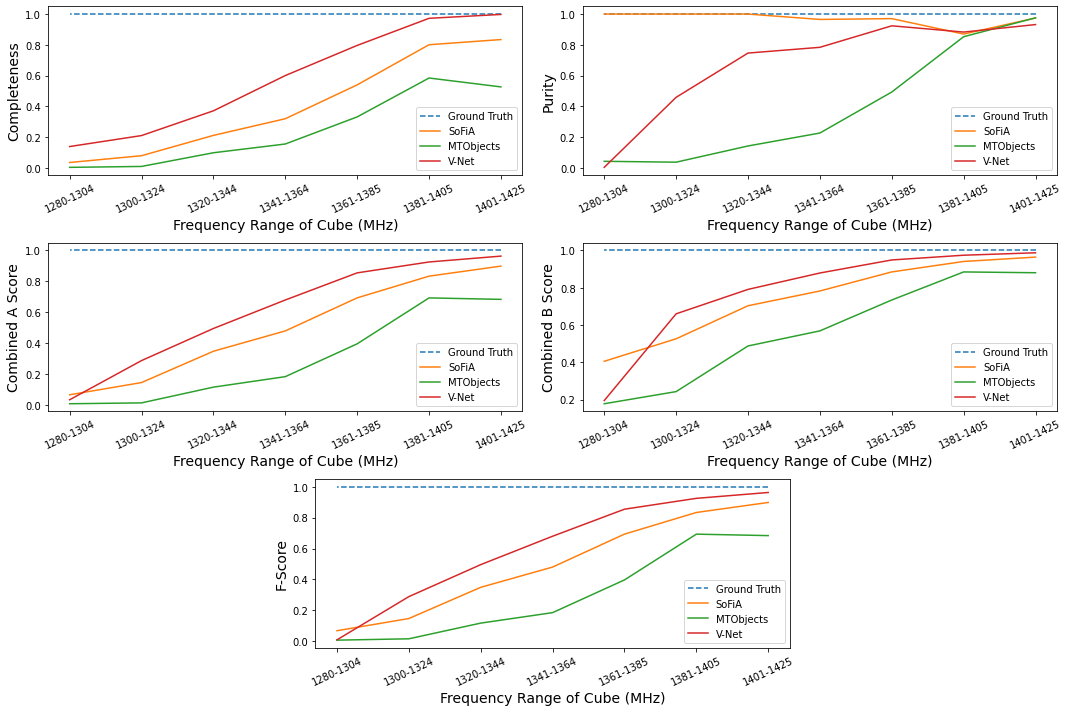

In [223]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))
gs = fig.add_gridspec(3, 4)
ax1 = fig.add_subplot(gs[0, :2])
ax1.set_ylabel("Completeness", fontsize=14)
ax1.set_xticks(ticks=full_mto_df.freq_1)
ax1.set_xticklabels(full_mto_df.freq_labels, rotation=25)
ax1.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax1.plot(full_mto_df.freq_1, [1]*7, label="Ground Truth", linestyle="--")
ax1.plot(full_mto_df.freq_1, full_sofia_df.recall, label="SoFiA")
ax1.plot(full_mto_df.freq_1, full_mto_df.recall, label="MTObjects")
ax1.plot(full_vnet_df.freq_1, full_vnet_df.recall, label="V-Net")
ax1.legend()

ax2 = fig.add_subplot(gs[0, 2:4])

ax2.set_ylabel("Purity", fontsize=14)
ax2.set_xticks(ticks=full_mto_df.freq_1)
ax2.set_xticklabels(full_mto_df.freq_labels, rotation=25)
ax2.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax2.plot(full_mto_df.freq_1, [1]*7, label="Ground Truth", linestyle="--")
ax2.plot(full_mto_df.freq_1, full_sofia_df.precision, label="SoFiA")
ax2.plot(full_mto_df.freq_1, full_mto_df.precision, label="MTObjects")
ax2.plot(full_vnet_df.freq_1, full_vnet_df.precision, label="V-Net")
ax2.legend()

ax3 = fig.add_subplot(gs[1, :2])
ax3.set_ylabel("Combined A Score", fontsize=14)
ax3.set_xticks(ticks=full_mto_df.freq_1)
ax3.set_xticklabels(full_mto_df.freq_labels, rotation=25)
ax3.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax3.plot(full_mto_df.freq_1, [1]*7, label="Ground Truth", linestyle="--")
ax3.plot(full_mto_df.freq_1, full_sofia_df.combined_one, label="SoFiA")
ax3.plot(full_mto_df.freq_1, full_mto_df.combined_one, label="MTObjects")
ax3.plot(full_vnet_df.freq_1, full_vnet_df.combined_one, label="V-Net")
ax3.legend()

ax4 = fig.add_subplot(gs[1, 2:4])
ax4.set_ylabel("Combined B Score", fontsize=14)
ax4.set_xticks(ticks=full_mto_df.freq_1)
ax4.set_xticklabels(full_mto_df.freq_labels, rotation=25)
ax4.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax4.plot(full_mto_df.freq_1, [1]*7, label="Ground Truth", linestyle="--")
ax4.plot(full_mto_df.freq_1, full_sofia_df.combined_two, label="SoFiA")
ax4.plot(full_mto_df.freq_1, full_mto_df.combined_two, label="MTObjects")
ax4.plot(full_vnet_df.freq_1, full_vnet_df.combined_two, label="V-Net")
ax4.legend()

ax5 = fig.add_subplot(gs[2, 1:3])
ax5.set_ylabel("F-Score", fontsize=14)
ax5.set_xticks(ticks=full_mto_df.freq_1)
ax5.set_xticklabels(full_mto_df.freq_labels, rotation=25)
ax5.plot(full_mto_df.freq_1, [1]*7, label="Ground Truth", linestyle="--")
ax5.plot(full_mto_df.freq_1, full_sofia_df.f_score, label="SoFiA")
ax5.plot(full_mto_df.freq_1, full_mto_df.f_score, label="MTObjects")
ax5.plot(full_vnet_df.freq_1, full_vnet_df.f_score, label="V-Net")
ax5.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax5.legend()

fig.tight_layout()

Add filters (set to false detections) - choose from masks:
- all spatial distributions below beam size and above 0.3Mpc
- all spectral filters lower than 7km/s and above 750 km/s 

In [231]:
noise_res = [(15*u.arcsec).to(u.deg), (25*u.arcsec).to(u.deg)]
kpc_lim = [0, 0.3*1e3]
n_vel_lim = [7, 750]

In [232]:
cond = (
    (mask_cat_df.nx*d_width < noise_res[0]) | (mask_cat_df.ny*d_width < noise_res[1]) | 
    (mask_cat_df.ny_kpc > kpc_lim[1]) | (mask_cat_df.nx_kpc > kpc_lim[1]) |
    (mask_cat_df.n_vel > n_vel_lim[1]) | (mask_cat_df.n_vel < n_vel_lim[0])
)
print(len(mask_cat_df[cond]), "false positives flagged out of ", len(mask_cat_df))


0 false positives flagged out of  4272


In [233]:
cond1 = (
    (mto_cat_df.nx*d_width < noise_res[0]) | (mto_cat_df.ny*d_width < noise_res[1]) | 
    (mto_cat_df.ny_kpc > kpc_lim[1]) | (mto_cat_df.nx_kpc > kpc_lim[1]) |
    (mto_cat_df.n_vel > n_vel_lim[1]) | (mto_cat_df.n_vel < n_vel_lim[0])
)
print(len(mto_cat_df[cond1 & mto_cat_df.true_positive_real]), "false positives flagged out of ", len(mto_cat_df[mto_cat_df.true_positive_real]))
print(len(mto_cat_df[cond1 & mto_cat_df.true_positive_mocks]), "false positives flagged out of ", len(mto_cat_df[mto_cat_df.true_positive_mocks]))
mto_cat_df.loc[cond1, 'true_positive_real'] = False
mto_cat_df.loc[cond1, 'true_positive_mocks'] = False


18152 false positives flagged out of  26139
45 false positives flagged out of  1903


In [234]:
cond2 = (
    (sofia_cat_df.nx*d_width < noise_res[0]) | (sofia_cat_df.ny*d_width < noise_res[1]) | 
    (sofia_cat_df.ny_kpc > kpc_lim[1]) | (sofia_cat_df.nx_kpc > kpc_lim[1]) |
    (sofia_cat_df.n_vel > n_vel_lim[1]) | (sofia_cat_df.n_vel < n_vel_lim[0])
)
print(len(sofia_cat_df[cond2 & sofia_cat_df.true_positive_real]), "false positives flagged out of ", len(sofia_cat_df[sofia_cat_df.true_positive_real]))
print(len(sofia_cat_df[cond2 & sofia_cat_df.true_positive_mocks]), "false positives flagged out of ", len(sofia_cat_df[sofia_cat_df.true_positive_mocks]))
sofia_cat_df.loc[cond2, 'true_positive_real'] = False
sofia_cat_df.loc[cond2, 'true_positive_mocks'] = False


8 false positives flagged out of  42
148 false positives flagged out of  1621


### Compare detections found by both methods

In [235]:
result = pd.merge(sofia_cat_df, mto_cat_df, on=["mos_name", "max_loc"], suffixes=("_sofia", "_mto"), how='outer')
print(len(result[result.true_positive_real_mto & result.true_positive_real_sofia]), "Overlapping real detections")
print(len(result[result.true_positive_mocks_mto & result.true_positive_mocks_sofia]), "Overlapping mock detections")
masks_too = pd.merge(result, mask_cat_df, on=["mos_name", "max_loc"], how='left')
intersection = masks_too[(~masks_too.area_sofia.isnull()) & (~masks_too.area_mto.isnull())]


2 Overlapping real detections
1260 Overlapping mock detections


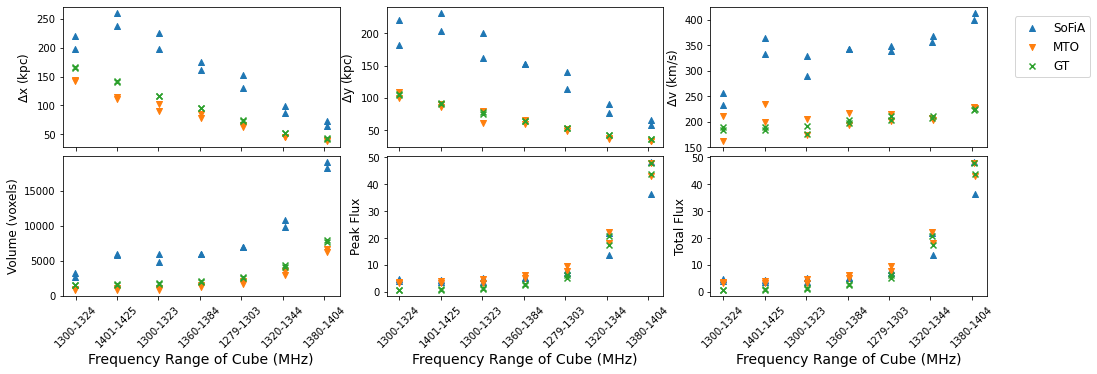

In [236]:
freq_labels = ['1279.96-1304', '1300.18-1324', '1320.39-1344', '1340.61-1364', '1360.82-1385', '1381.04-1405', '1401.25-1425']
fig, axes = plt.subplots(2, 3, figsize=(15,5), sharex=True) #, sharey=True, sharex=True)
# fig.suptitle("Mean properties galaxies detected in each cube", fontsize=15)
j = 0
labels = {"area": "Volume (voxels)", "peak_flux": "Peak Flux", "nx_kpc": r"$\Delta$x (kpc)", "ny_kpc": r"$\Delta$y (kpc)", "n_vel": r"$\Delta$v (km/s)", "tot_flux": "Total Flux"}
for i, col in enumerate(["nx_kpc", "ny_kpc", "n_vel", "area", "peak_flux", "tot_flux"]):
    if i == 3:
        j += 1
    if i >= 3:
        i = i - 3
        axes[j][i].set_xticklabels(sofia_cat_df.freq_label.unique(), rotation=45)
        axes[j][i].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
    sof = sofia_cat_df[sofia_cat_df.true_positive_mocks].groupby('start_freq')[col].mean()
    mto = mto_cat_df[mto_cat_df.true_positive_mocks].groupby('start_freq')[col].mean()
    mask = mask_cat_df.groupby('start_freq')[col].mean()

    axes[j][i].scatter(sof.index, sof, label="SoFiA", marker='^')
    axes[j][i].scatter(mto.index, mto, label="MTO", marker='v')
    axes[j][i].scatter(mask.index, mask, label="GT", marker='x')
    axes[j][i].set_ylabel(labels[col], fontsize=12)
#     axes[i].tick_params(axis='y', labelsize=16)

axes[0][2].legend(loc=(1.1, 0.5), fontsize=12)
fig.tight_layout(pad=0)

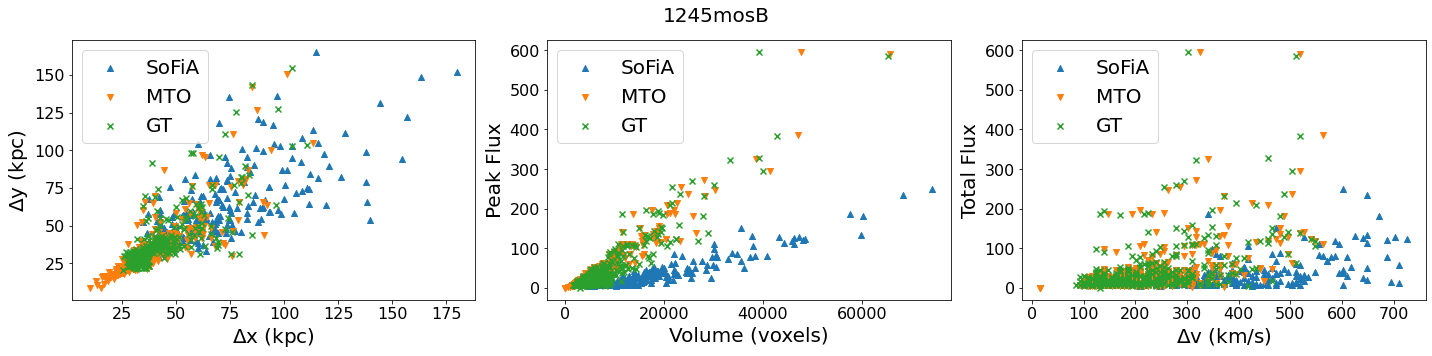

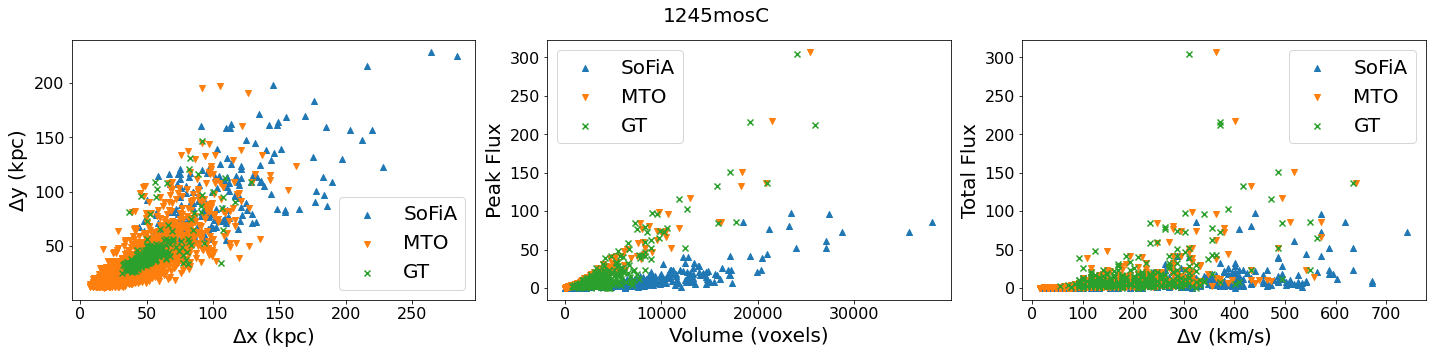

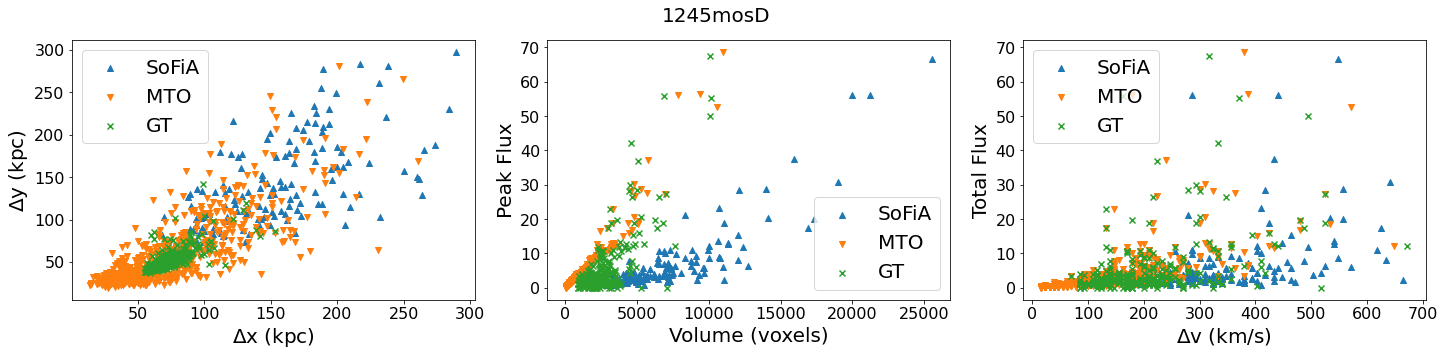

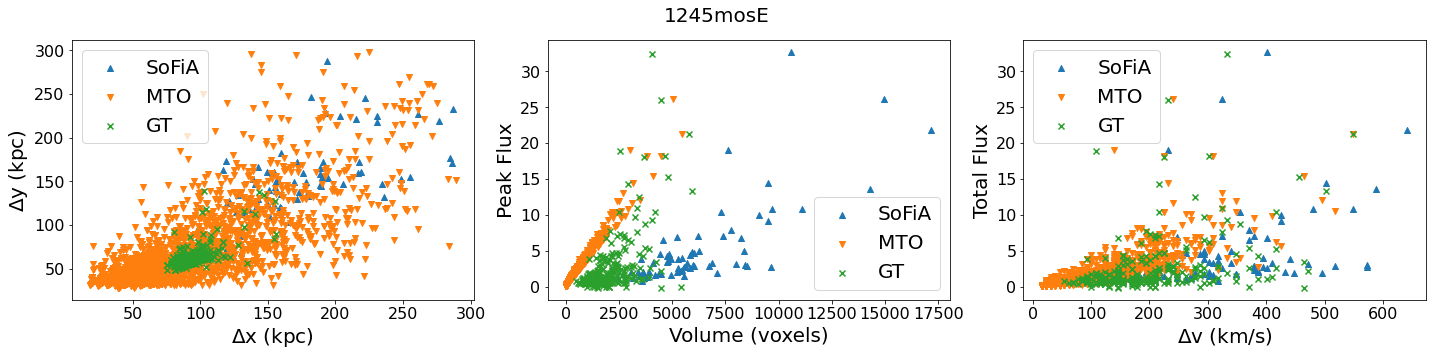

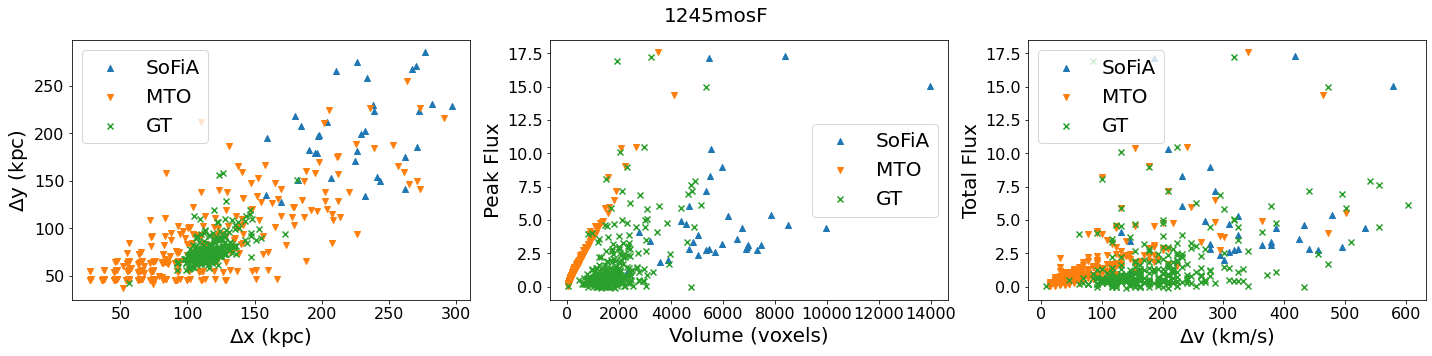

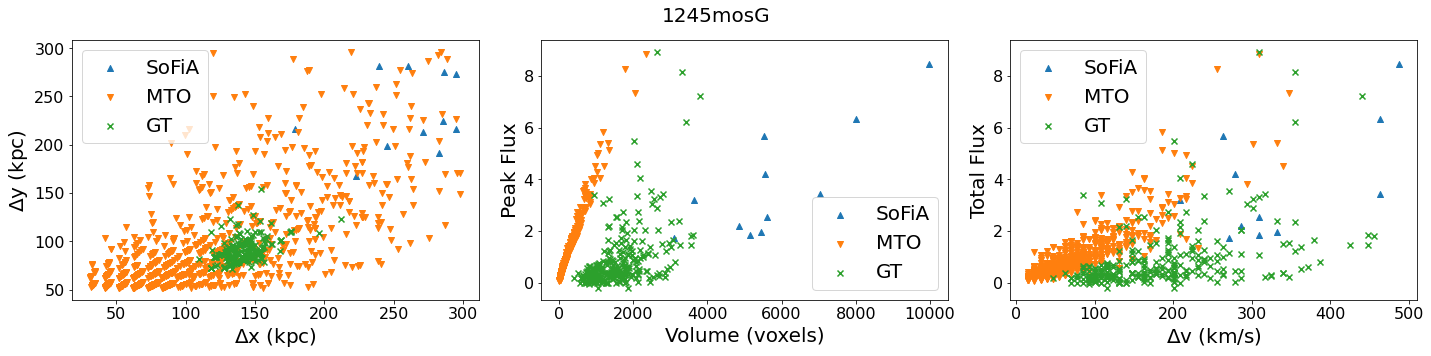

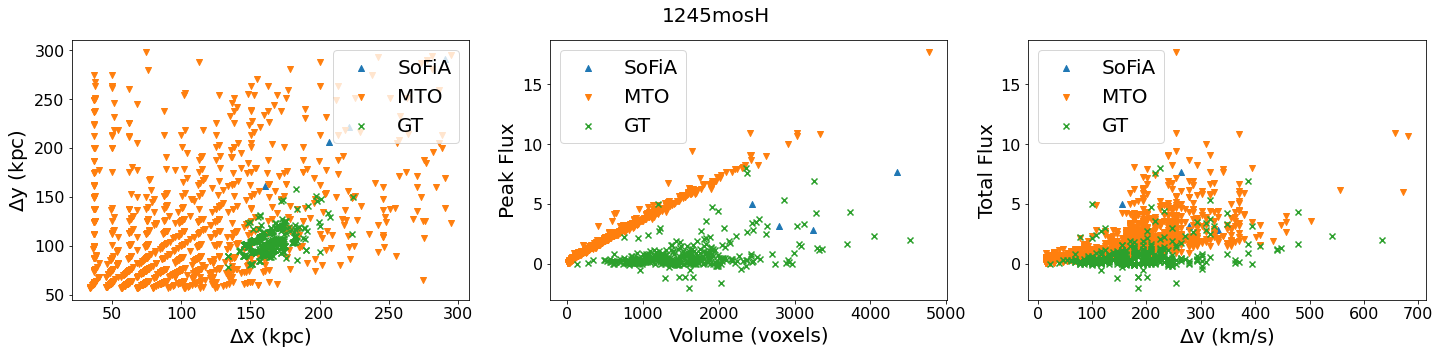

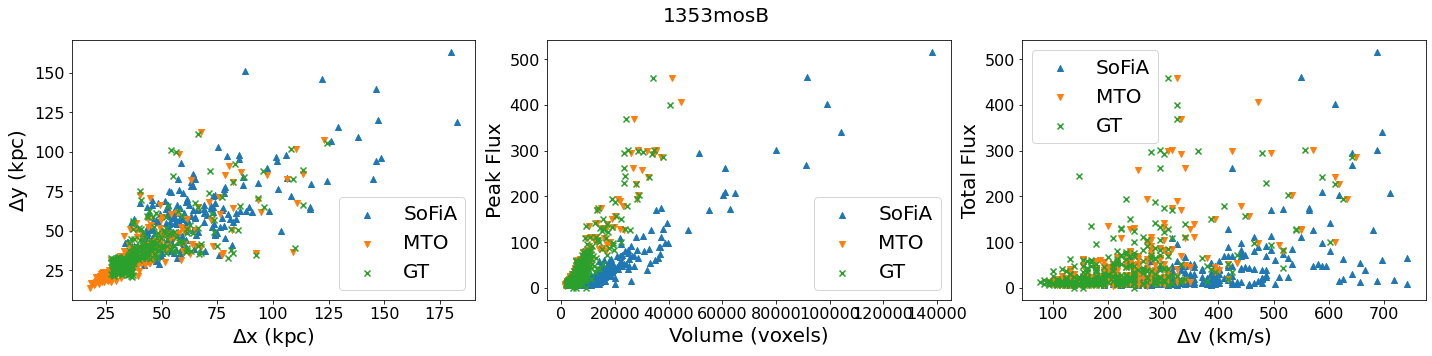

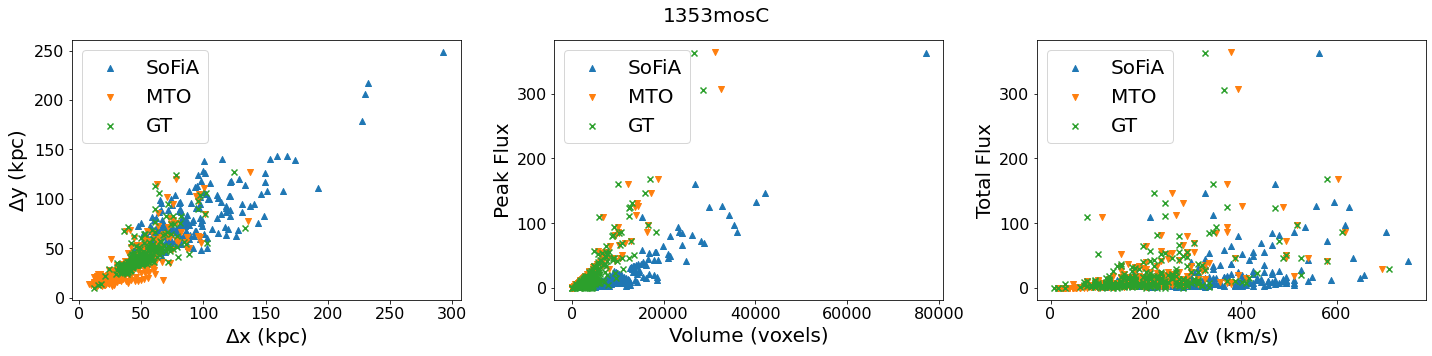

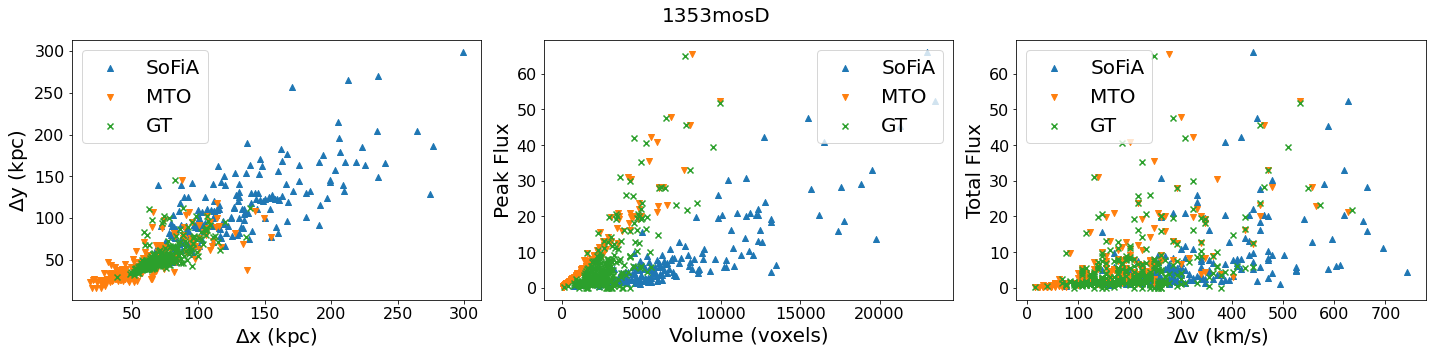

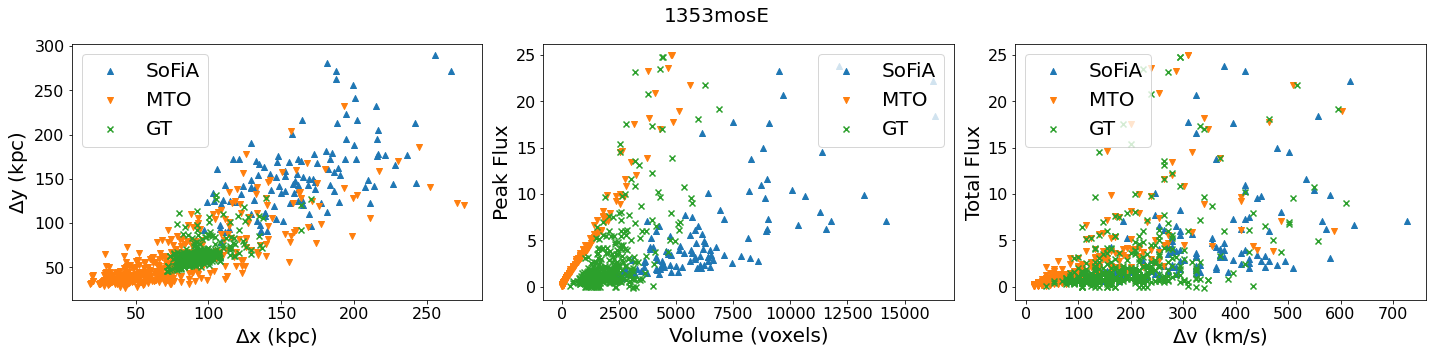

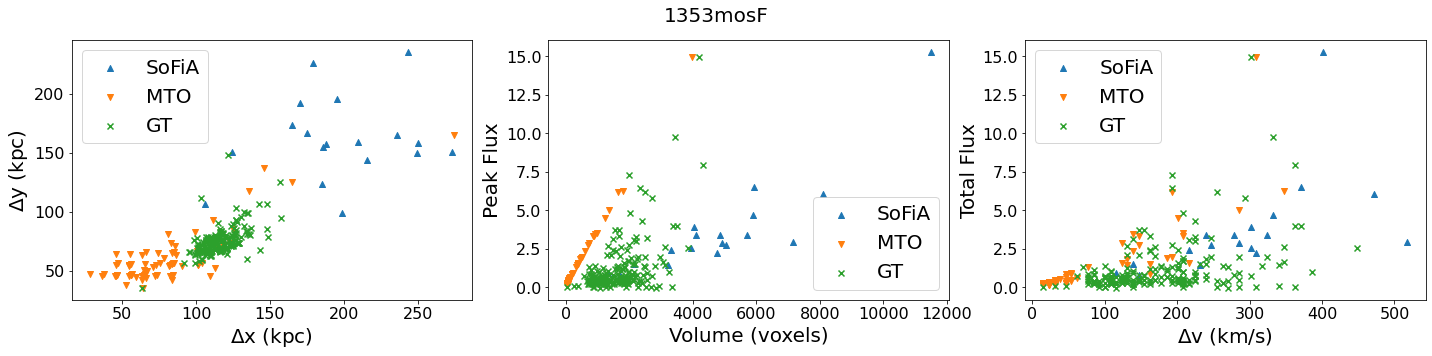

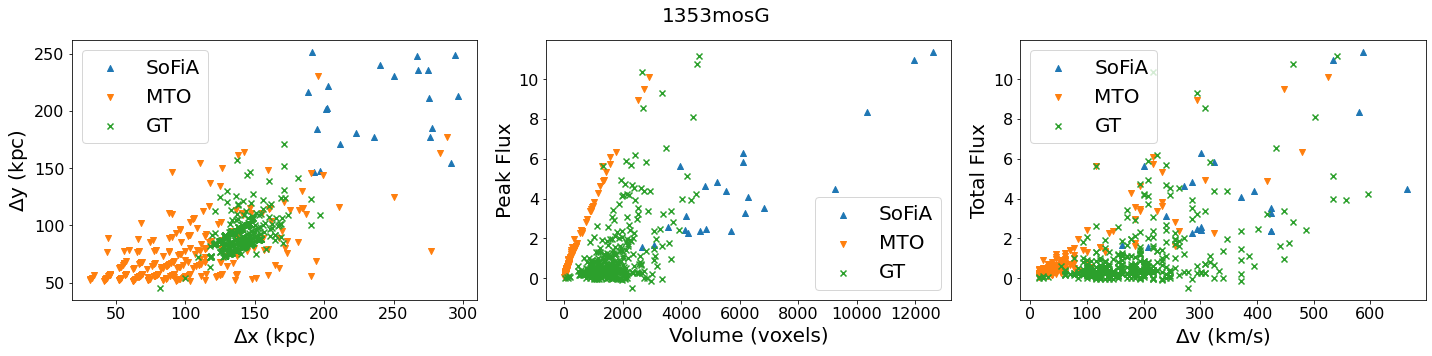

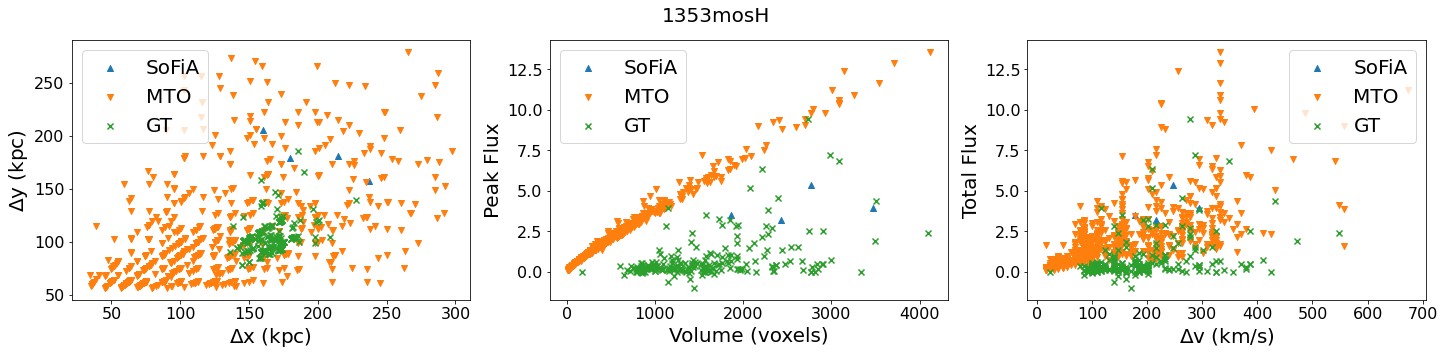

In [135]:
tp_sof = sofia_cat_df[sofia_cat_df.true_positive_mocks | sofia_cat_df.true_positive_real]
tp_mto = mto_cat_df[mto_cat_df.true_positive_mocks | mto_cat_df.true_positive_real]

for cube in np.sort(mask_cat_df.mos_name.unique()):
    fig, axes = plt.subplots(1, 3, figsize=(20,5)) #, sharey=True, sharex=True)
    fig.suptitle(cube, fontsize=20)
    axes[0].scatter(tp_sof[tp_sof.mos_name==cube].nx_kpc, tp_sof[tp_sof.mos_name==cube].ny_kpc, label="SoFiA", marker='^')
    axes[0].scatter(tp_mto[tp_mto.mos_name==cube].nx_kpc, tp_mto[tp_mto.mos_name==cube].ny_kpc, label="MTO", marker='v')
    axes[0].scatter(mask_cat_df[mask_cat_df.mos_name==cube].nx_kpc, mask_cat_df[mask_cat_df.mos_name==cube].ny_kpc, label="GT", marker='x')
    axes[0].set_xlabel(r"$\Delta$x (kpc)", fontsize=20)
    axes[0].set_ylabel(r"$\Delta$y (kpc)", fontsize=20)
    axes[0].legend(fontsize=20)
    axes[0].tick_params(axis='x', labelsize=16)
    axes[0].tick_params(axis='y', labelsize=16)


    axes[1].scatter(tp_sof[tp_sof.mos_name==cube].area, tp_sof[tp_sof.mos_name==cube].peak_flux, label="SoFiA", marker='^')
    axes[1].scatter(tp_mto[tp_mto.mos_name==cube].area, tp_mto[tp_mto.mos_name==cube].peak_flux, label="MTO", marker='v')
    axes[1].scatter(mask_cat_df[mask_cat_df.mos_name==cube].area, mask_cat_df[mask_cat_df.mos_name==cube].peak_flux, label="GT", marker='x')
    axes[1].set_xlabel("Volume (voxels)", fontsize=20)
    axes[1].set_ylabel("Peak Flux", fontsize=20)
    axes[1].legend(fontsize=20)
    axes[1].tick_params(axis='x', labelsize=16)
    axes[1].tick_params(axis='y', labelsize=16)
    # axes[1].set_ylim(-50, 400)

    axes[2].scatter(tp_sof[tp_sof.mos_name==cube].n_vel, tp_sof[tp_sof.mos_name==cube].tot_flux, label="SoFiA", marker='^')
    axes[2].scatter(tp_mto[tp_mto.mos_name==cube].n_vel, tp_mto[tp_mto.mos_name==cube].tot_flux, label="MTO", marker='v')
    axes[2].scatter(mask_cat_df[mask_cat_df.mos_name==cube].n_vel, mask_cat_df[mask_cat_df.mos_name==cube].tot_flux, label="GT", marker='x')
    axes[2].set_xlabel(r"$\Delta$v (km/s)", fontsize=20)
    axes[2].set_ylabel("Total Flux", fontsize=20)
    axes[2].legend(fontsize=20)
    axes[2].tick_params(axis='x', labelsize=16)
    axes[2].tick_params(axis='y', labelsize=16)
    # axes[2].set_ylim(-50, 400)

    fig.tight_layout()

- Sorted by the ground truth values
- Note that outliers have been removed with filters
- SoFiA overestimates while MTO underestimates
- Become less and less similar as frequencies decrease but so few detected sources makes it difficult to tell

### Insert into GT masks
Insert false positives that were cross-referenced and found to be real sources

In [ ]:
intersection['Class'] = 'FP'
intersection.loc[intersection.true_positive_mocks_mto | intersection.true_positive_real_mto
                 | intersection.true_positive_mocks_sofia | intersection.true_positive_real_sofia, 'Class'] = 'TP'

In [ ]:
# cols_to_keep = ['mos_name', 'max_loc', 'area', 'peak_flux', 'elongation', 'flatness',
#                 'tot_flux', 'true_positive_mocks', 'true_positive_real','file',
#                'n_vel', 'nx_mpc', 'ny_mpc']
# result = pd.merge(sofia_cat_df[cols_to_keep], mto_cat_df[cols_to_keep], on=["mos_name", "max_loc"], suffixes=("_sofia", "_mto"), how='outer')
# len(sofia_cat_df[cols_to_keep]) + len(mto_cat_df[cols_to_keep]), len(result) + len(result[(~result.area_sofia.isnull()) & (~result.area_mto.isnull())])

In [ ]:
comb_df = pd.DataFrame(np.nan, index=result.index, columns=cols_to_keep)
for col in cols_to_keep:
    if col in ['max_loc', 'mos_name']:
        comb_df[col] = result[col]
        continue
    if col == 'file':
        continue
    cond_mto = ~result[col+"_mto"].isnull() & result[col+"_sofia"].isnull()
    cond_sofia = ~result[col+"_sofia"].isnull() & result[col+"_mto"].isnull()
    cond_both_sofia = (result.area_sofia >= result.area_mto) & ~result[col+"_sofia"].isnull() & ~result[col+"_mto"].isnull()
    cond_both_mto = ~(result.area_sofia >= result.area_mto) & ~result[col+"_sofia"].isnull() & ~result[col+"_mto"].isnull()
    comb_df.loc[cond_mto, col] = result[cond_mto][col+"_mto"]
    comb_df.loc[cond_mto, "file"] = result[cond_mto].file_mto
    comb_df.loc[cond_sofia, col] = result[cond_sofia][col+"_sofia"]
    comb_df.loc[cond_sofia, "file"] = result[cond_sofia].file_sofia
    comb_df.loc[cond_both_mto, col] = result[cond_both_mto][col+"_mto"]
    comb_df.loc[cond_both_mto, "file"] = result[cond_both_mto].file_mto
    comb_df.loc[cond_both_sofia, col] = result[cond_both_sofia][col+"_sofia"]
    comb_df.loc[cond_both_sofia, "file"] = result[cond_both_sofia].file_sofia
comb_df['mos_name'] = comb_df.file.str.split("_", expand=True)[3].str.replace(".fits", "")
comb_df.head()

In [ ]:
for file_name in comb_df.mos_name.unique():
    mask_file = "../data/training/Target/mask_" + file_name + ".fits"
    try:
        gt_cube = fits.getdata(mask_file)
        print(mask_file)
        subset = comb_df[(~comb_df.true_positive_mocks) & comb_df.true_positive_real & (comb_df.mos_name == file_name)]
        for  i, row in subset.iterrows():
            print(i)
            try:
                new_mask = fits.getdata("../" + row.file)[
                    int(row['bbox-0']):int(row['bbox-3']),
                    int(row['bbox-1']):int(row['bbox-4']),
                    int(row['bbox-2']):int(row['bbox-5'])
                ]
                new_mask[new_mask > 0] = 1
                gt_cube[
                    int(row['bbox-0']):int(row['bbox-3']),
                    int(row['bbox-1']):int(row['bbox-4']),
                    int(row['bbox-2']):int(row['bbox-5'])
                ] = new_mask
            except:
                continue
#         new_file = "../data/training/TargetCat/mask_" + file_name + ".fits"
#         fits.write_to(new_file, gt_cube)
    except:
        continue

In [13]:
mask_labels = skmeas.label(gt_cube)
len(np.unique(mask_labels))

326

In [8]:
mask_labels = skmeas.label(gt_cube)
len(np.unique(mask_labels))

415

## Train ML to identify tps

In [5]:
comb_df['Class'] = comb_df.true_positive_mocks | comb_df.true_positive_real

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    comb_df[['area', 'peak_flux', 'eccentricity', 'flatness', 'brightest_pix',
             'n_channels', 'nx', 'ny', 'tot_flux']],
    comb_df.Class.astype(int), test_size=0.33, random_state=42)

In [9]:
logit_model = LogisticRegression(class_weight='balanced', max_iter=1000)
tree_model = tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced') 
svm_model = SVC(probability=True, class_weight='balanced')
knn_model = KNeighborsClassifier(n_neighbors=3)
bayes_model = GaussianNB()
models = [logit_model, tree_model, rf, svm_model, knn_model, bayes_model]

accuracy = []
precision = []
recall = []
f1 = []

In [10]:

for model in models:
    model.fit(x_train, y_train)
    predicted = pd.DataFrame(model.predict(x_test))
    accuracy += [metrics.accuracy_score(y_test, predicted)]
    precision += [metrics.precision_score(y_test, predicted, pos_label=1)]
    recall += [metrics.recall_score(y_test, predicted, pos_label=1)]
    f1 += [metrics.f1_score(y_test, predicted, pos_label=1)]

results = pd.DataFrame([accuracy, precision, recall, f1]).T
results.columns = ["accuracy", "precision", "recall", "f1"]
results.index = ["LR", "DT", "RF", "SVM", "KNN", "Bayes"]
results.sort_values("f1", ascending=False)

,accuracy,precision,recall,f1
RF,0.851049,0.773450,0.354985,0.486626
DT,0.791268,0.472767,0.430514,0.450652
KNN,0.813949,0.546545,0.378399,0.447188
LR,0.199119,0.198918,1.000000,0.331830
Bayes,0.808592,0.603043,0.109768,0.185729
SVM,0.817403,0.849462,0.099446,0.178048
